In [40]:
from sympy import symbols, init_printing
import sympy
import sympy.physics.mechanics as me
from pydy.system import System
init_printing(use_latex='mathjax')
import matplotlib.pyplot as plt
from scipy.integrate import ode, odeint
import numpy as np
%matplotlib inline

N = me.ReferenceFrame('N')
B = me.ReferenceFrame('B')

theta, F, M = me.dynamicsymbols('theta F M')
theta_dot = me.dynamicsymbols('theta',1)
a, b, m, t, Izz = sympy.symbols('a b m t Izz')

B.orient(N, 'Axis', (theta, N.z))
B.set_ang_vel(N, theta_dot * N.z)

In [99]:
G = me.Point('G')
P = me.Point('P')
L = me.Point('L')
G.set_vel(N, 0)
P.set_pos(G, -a/2 * B.x + b/2 * B.y)
L.set_pos(G, -a/2 * B.x - b/2 * B.y)
P.v2pt_theory(G,N,B)
L.v2pt_theory(G,N,B)

  d       
b⋅──(θ(t))
  dt      
──────────
    2      b_x +    d        
-a⋅──(θ(t)) 
   dt       
────────────
     2       b_y

In [100]:
I_plate = me.inertia(N, 0, 0, Izz)
inertia_plate = (I_plate, G)
Plate = me.RigidBody('Plate', G, B, m, inertia_plate)
Plate.potential_energy = 0

In [121]:
force = (P, F * N.x)
force_bal = (L, -F * N.x)
moment = (B, M * N.z)

In [122]:
Lag = me.Lagrangian(N, Plate)

LM = me.LagrangesMethod(Lag, [theta], forcelist=[moment, force, force_bal], frame=N)

EqMotion = LM.form_lagranges_equations()

lrhs = LM.rhs()

plate_height = 2
plate_width = 4
plate_mass = 5
inertia = (plate_height**2 + plate_width**2) * (plate_mass/12.0)

In [123]:
def bang(F_amp, StartTime1, EndTime1, t):
    f = F_amp * (t >= StartTime1) * (t <= EndTime1)
    return f

In [124]:
# Define the states and state vector
w1, w2 = sympy.symbols('w1 w2', cls=sympy.Function)
w = [w1(t), w2(t)]

# Set up the state definitions and parameter substitution
sub_params = {theta : w1(t),
              theta_dot : w2(t),
              m : plate_mass,
              a : plate_width,
              b : plate_height,
              F: 1,
              M: 0,
              Izz: inertia}

# set this parameter to enable array output from sympy.lambdify
mat2array = [{'ImmutableMatrix': np.array}, 'numpy']

# Create a function from the equations of motion
# Here, we substitude the states and parameters as appropriate prior to the lamdification
eq_of_motion = sympy.lambdify((t, w),
                              lrhs.subs(sub_params),
                              modules = mat2array)


x0 = [0,0]
# -0.07848
# Positive beta is to the left when facing the structure
sim_time = np.linspace(0.0, 20, 1000)


# In[33]:

# Set up the initial point for the ode solver
r = ode(eq_of_motion).set_initial_value(x0, sim_time[0])

# define the sample time
dt = sim_time[1] - sim_time[0]

# pre-populate the response array with zeros
response = np.zeros((len(sim_time), len(x0)))

# Set the initial index to 0
index = 0

# Now, numerically integrate the ODE while:
#   1. the last step was successful
#   2. the current time is less than the desired simluation end time
while r.successful() and r.t < sim_time[-1]:
    response[index, :] = r.y
    r.integrate(r.t + dt)
    index += 1

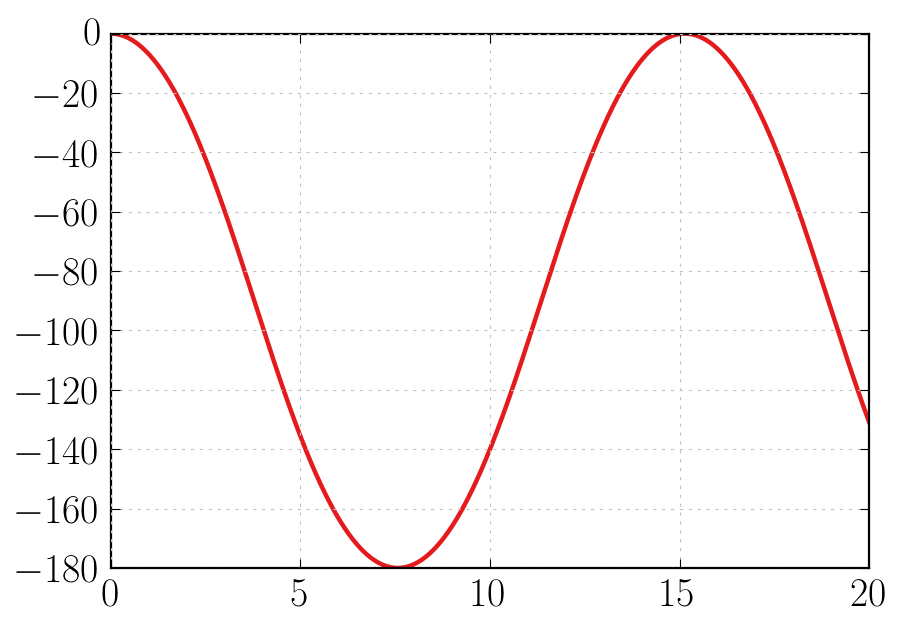

In [125]:
plt.plot(sim_time,np.degrees(response[:,0]))

Processing frame 0
Processing frame 30
Processing frame 60
Processing frame 90
Processing frame 120
Processing frame 150
Processing frame 180
Processing frame 210
Processing frame 240
Processing frame 270


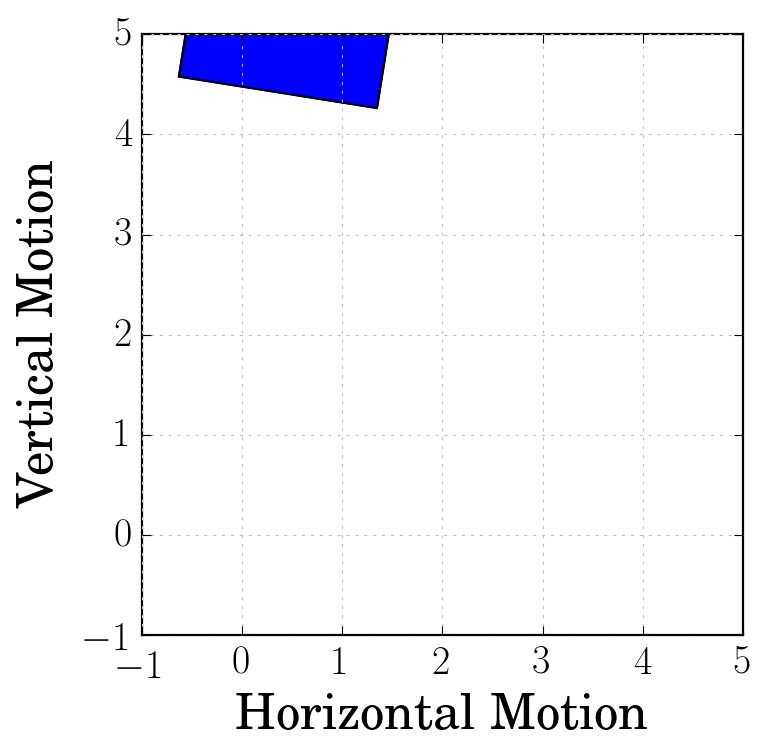

In [50]:
import matplotlib.animation as animation
beta=response[:,0]
lenn = np.sqrt(plate_height**2 + plate_width**2)
# Change some plot properties to make the video work and look better
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
mpl.rcParams['savefig.dpi'] = 160
mpl.rcParams['savefig.bbox'] = 'standard'
fig = plt.figure(figsize=(8,4.5))
ax = fig.add_subplot(111, aspect='equal')
plt.ylim(-1,5)
plt.xlim(-1,5)
plt.xlabel('Horizontal Motion', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Vertical Motion', fontsize=22, weight='bold', labelpad=10)
# plt.axes().set_aspect('equal')

patch = patches.Rectangle((0, 0), 0, 0, angle=0)

def init():
    """ Initialize the lines in the plot """
    ax.add_patch(patch)

    return patch,

def animate_un(i):
    """ Update the plot for frame i """
    if not (i % 30): # print notice every 30th frame
        print('Processing frame {}'.format(i))
    patch.set_width(plate_width)
    patch.set_height(plate_height)
    patch.set_xy([lenn*np.sin(beta[i]-1.10714871779), lenn*np.cos(beta[i]-1.10714871779)])
    patch._angle = np.rad2deg(beta[i])

    return patch,

ani_un = animation.FuncAnimation(fig, animate_un, interval = 30, frames = 300,
                                 blit = True, init_func = init)
# ani_s = animation.FuncAnimation(fig, animate_s, interval = 30, frames = 300,
#                                 blit = True, init_func = init)

ani_un.save('compress.mp4', bitrate = 2500, fps = 30)
# ani_s.save('ZVEI2mode.mp4', bitrate = 2500, fps = 30)